In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from os import listdir
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [2]:
class SimpsonsDataset(Dataset):
    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms
        simpsons = listdir('/kaggle/input/journey-springfield/train/simpsons_dataset')
        self.classes_labels =  dict(zip(range(len(simpsons)), simpsons))
        self.classes_simpsons = dict(zip(simpsons, range(len(simpsons))))
        self.images = []
        self.labels = []
        for class_dir in listdir('/kaggle/input/journey-springfield/train/simpsons_dataset'):
            for image in listdir(f'/kaggle/input/journey-springfield/train/simpsons_dataset/{class_dir}'):
                self.images.append(f'/kaggle/input/journey-springfield/train/simpsons_dataset/{class_dir}/{image}')
                self.labels.append(self.classes_simpsons[class_dir])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, item):
        img = Image.open(self.images[item])
        return self.transforms(img), self.labels[item]

проверяем доступ к видеокарте

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
transforms = v2.Compose([v2.ToTensor(),
                         v2.Resize((224, 224), antialias=True),
                         v2.ToDtype(torch.float32, scale=True),
                         v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
train_set = SimpsonsDataset(transforms)
classes_labels = train_set.classes_labels

In [6]:
train_set, val_set = train_test_split(train_set, test_size=0.2, shuffle=True, stratify=train_set.labels, random_state=13)

In [7]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = nn.Linear(2048, len(classes_labels), bias=True)
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction='sum')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 164MB/s]


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, val_losses, train_f1s, val_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[1].plot(range(1, len(val_f1s) + 1), val_f1s, label='val')
    axs[1].set_ylabel('f1')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    
    plt.title(f'Train f1: {train_f1s[-1]}, val f1: {val_f1s[-1]}')
    
    plt.show()

функция для отрисовки метрики и лоса

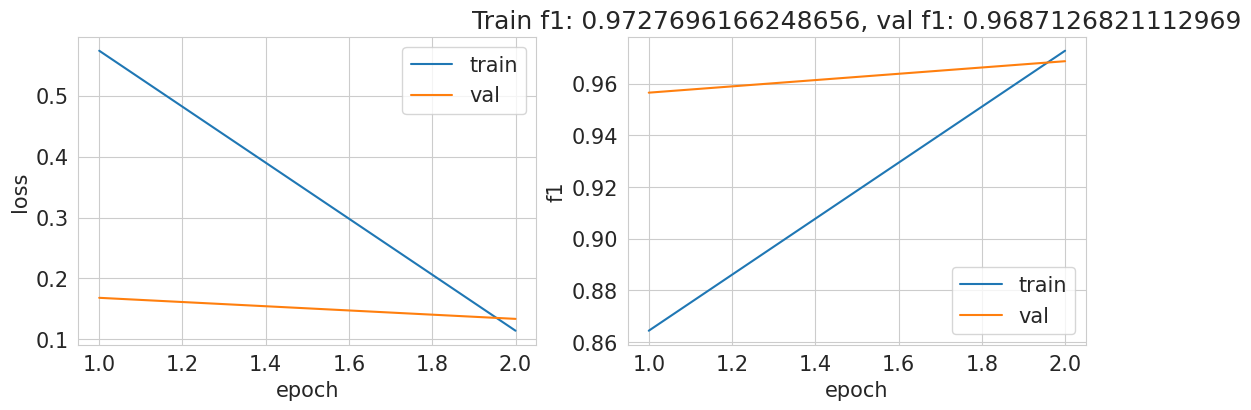

In [10]:
NUM_EPOCHS = 2
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, running_f1 = 0, 0
    for imgs, labels in tqdm(train_loader, desc='Training'):
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_f1 += f1_score(labels.cpu(), logits.argmax(1).cpu(), average='micro') * len(imgs)
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader.dataset))
    train_f1s.append(running_f1 / len(train_loader.dataset))
    model.eval()
    running_loss, running_f1 = 0, 0
    for imgs, labels in tqdm(val_loader, desc='Validating'):
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(imgs)
            loss = criterion(logits, labels)
            running_loss += loss.item()
            running_f1 += f1_score(labels.cpu(), logits.argmax(1).cpu(), average='micro') * len(imgs)
    val_losses.append(running_loss / len(val_loader.dataset))
    val_f1s.append(running_f1 / len(val_loader.dataset))
    plot_losses(train_losses, val_losses, train_f1s, val_f1s)

In [11]:
preds = []
out = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
model.eval()
for name in out['Id']:
    img = Image.open(f'/kaggle/input/journey-springfield/testset/testset/{name}')
    img = transforms(img).unsqueeze(0).to(device)
    logit = model(img).squeeze()
    preds.append(logit.argmax().item())
preds = list(map(lambda x: classes_labels[x], preds))
out['Expected'] = preds

In [12]:
out.to_csv('/kaggle/working/submission.csv', index=False)